# 최적화

In [67]:
d_input = d_input_nophq_notarget
d_target = df_all["target"]
x_train, x_test, y_train, y_test = train_test_split(d_input, d_target, random_state=None)

In [106]:
import pickle

# with open('x_train.pickle', 'wb') as f:
#     pickle.dump(x_train, f)

# with open('x_test.pickle', 'wb') as f:
#     pickle.dump(x_test, f)

# with open('y_train.pickle', 'wb') as f:
#     pickle.dump(y_train, f)

# with open('y_test.pickle', 'wb') as f:
#     pickle.dump(y_test, f)

In [63]:
with open('x_train.pickle', 'rb') as f:
    x_train = pickle.load(f)

with open('x_test.pickle', 'rb') as f:
    x_test = pickle.load(f)
    
with open('y_train.pickle', 'rb') as f:
    y_train = pickle.load(f)
    
with open('y_test.pickle', 'rb') as f:
    y_test = pickle.load(f)

In [64]:
with open('df_optimization.pickle', 'rb') as f:
    df_optimization = pickle.load(f)

with open('result_df.pickle', 'rb') as f:
    result_df = pickle.load(f)
    
with open('xgb_y_pred.pickle', 'rb') as f:
    xgb_y_pred = pickle.load(f)
    
with open('xgb_fi.pickle', 'rb') as f:
    xgb_fi = pickle.load(f)

## LGBMClassifier

In [68]:
from bayes_opt import BayesianOptimization
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import cross_validate
from bayes_opt.util import UtilityFunction

In [69]:
def evaluate_model(num_leaves, max_depth, learning_rate, n_estimators, subsample, colsample_bytree):
    model = LGBMClassifier(num_leaves=int(num_leaves),
                           max_depth=int(max_depth),
                           learning_rate=learning_rate,
                           n_estimators=int(n_estimators),
                           subsample=subsample,
                           colsample_bytree=colsample_bytree)
    score = cross_val_score(model, x_test,y_test, cv=5, scoring='accuracy').mean()
    return score

In [70]:
pbounds = {'num_leaves': (2, 50),
           'max_depth': (2, 20),
           'learning_rate': (0.01, 0.5),
           'n_estimators': (50, 500),
           'subsample': (0.5, 1),
           'colsample_bytree': (0.5, 1)}
optimizer = BayesianOptimization(f=evaluate_model, pbounds=pbounds, random_state=0)
optimizer.maximize(init_points=5, n_iter=20)

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.7466    | 0.7744    | 0.3604    | 12.85     | 295.2     | 22.34     | 0.8229    |
| 2         | 0.7641    | 0.7188    | 0.447     | 19.35     | 222.5     | 40.0      | 0.7644    |
| 3         | 0.7597    | 0.784     | 0.4635    | 3.279     | 89.21     | 2.97      | 0.9163    |
| 4         | 0.7596    | 0.8891    | 0.4363    | 19.62     | 409.6     | 24.15     | 0.8903    |
| 5         | 0.7857    | 0.5591    | 0.3236    | 4.58      | 475.1     | 27.05     | 0.7073    |
| 6         | 0.7553    | 0.8336    | 0.4937    | 5.92      | 476.8     | 25.18     | 0.5407    |
| 7         | 0.7727    | 0.6278    | 0.2701    | 4.404     | 491.9     | 42.28     | 0.6572    |
| 8         | 0.7989    | 0.8029    | 0.01632   | 13.08     | 235.8     | 49.6      | 0.7121    |
| 9         | 0.7901

In [71]:
lgbm_best_params = optimizer.max['params']
lgbm = LGBMClassifier(num_leaves=int(lgbm_best_params['num_leaves']),
                       max_depth=int(lgbm_best_params['max_depth']),
                       learning_rate=lgbm_best_params['learning_rate'],
                       n_estimators=int(lgbm_best_params['n_estimators']),
                       subsample=lgbm_best_params['subsample'],
                       colsample_bytree=lgbm_best_params['colsample_bytree'])

lgbm.fit(x_test, y_test)
lgbm_fi = lgbm.feature_importances_
lgbm_y_pred = lgbm.predict(x_test)
lgbm_accuracy = accuracy_score(y_test, lgbm_y_pred)
lgbm_accuracy

0.8122270742358079

In [72]:
lgbm_best_params

{'colsample_bytree': 0.6040907898855737,
 'learning_rate': 0.01,
 'max_depth': 12.107895322454748,
 'n_estimators': 94.22703325161635,
 'num_leaves': 2.0,
 'subsample': 0.829208379456038}

## RandomForestClassifier

In [73]:
def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    model = RandomForestClassifier(n_estimators=int(n_estimators),
                                   max_depth=int(max_depth),
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf)
    score = cross_val_score(model, x_test,y_test, cv=5, scoring='accuracy').mean()

    return score

In [74]:
# 베이지안 최적화할 하이퍼파라미터 공간 정의
pbounds = {'n_estimators': (10, 1000),
           'max_depth': (1, 100),
           'min_samples_split': (0.1, 1.0),
           'min_samples_leaf': (0.1, 0.5)}
# BayesianOptimization을 사용하여 모델 학습 및 최적화
bo_rf = BayesianOptimization(f=rf_cv, pbounds=pbounds, random_state=1)
bo_rf.maximize(init_points=5, n_iter=20)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.5066    | 42.29     | 0.3881    | 0.1001    | 309.3     |
| 2         | 0.7159    | 15.53     | 0.1369    | 0.2676    | 352.1     |
| 3         | 0.5154    | 40.28     | 0.3155    | 0.4773    | 688.4     |
| 4         | 0.5066    | 21.24     | 0.4512    | 0.1246    | 673.8     |
| 5         | 0.5286    | 42.31     | 0.3235    | 0.2263    | 206.1     |
| 6         | 0.5066    | 15.86     | 0.1387    | 0.9244    | 352.4     |
| 7         | 0.6724    | 44.81     | 0.2654    | 0.593     | 746.8     |
| 8         | 0.4979    | 62.72     | 0.1893    | 0.9632    | 806.6     |
| 9         | 0.5066    | 3.099     | 0.4232    | 0.9684    | 705.1     |
| 10        | 0.742     | 37.08     | 0.109     | 0.2372    | 971.8     |
| 11        | 0.5066    | 99.53     | 0.2301    | 0.8352    | 54.19     |
| 12        | 0.5066    | 98.14     | 

In [75]:
rf_best_params = bo_rf.max['params']
rf = RandomForestClassifier(n_estimators=int(rf_best_params['n_estimators']),
                            max_depth=int(rf_best_params['max_depth']),
                            min_samples_split=rf_best_params['min_samples_split'],
                            min_samples_leaf=rf_best_params['min_samples_leaf'])
rf.fit(x_train, y_train)
rf_fi = rf.feature_importances_
rf_y_pred = rf.predict(x_test)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_accuracy

0.7729257641921398

In [76]:
rf_best_params

{'max_depth': 37.07749996517543,
 'min_samples_leaf': 0.10895924445342381,
 'min_samples_split': 0.2371729115770744,
 'n_estimators': 971.8063086426878}

## GradientBoostingClassifier

In [77]:
def gbc_cv(learning_rate, n_estimators, max_depth, min_samples_split, min_samples_leaf):
    model = GradientBoostingClassifier(learning_rate=learning_rate,
                                       n_estimators=int(n_estimators),
                                       max_depth=int(max_depth),
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf)
    score = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy').mean()

    return score

In [78]:
# 베이지안 최적화할 하이퍼파라미터 공간 정의
pbounds = {'learning_rate': (0.01, 0.5),
           'n_estimators': (10, 1000),
           'max_depth': (1, 100),
           'min_samples_split': (0.1, 1.0),
           'min_samples_leaf': (0.1, 0.5)}

# BayesianOptimization을 사용하여 모델 학습 및 최적화
bo_gbc = BayesianOptimization(f=gbc_cv, pbounds=pbounds, random_state=1)
bo_gbc.maximize(init_points=5, n_iter=20)

|   iter    |  target   | learni... | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | 0.7445    | 0.2143    | 72.31     | 0.1       | 0.3721    | 155.3     |
| 2         | 0.7285    | 0.05525   | 19.44     | 0.2382    | 0.4571    | 543.4     |
| 3         | 0.7562    | 0.2154    | 68.84     | 0.1818    | 0.8903    | 37.11     |
| 4         | 0.7139    | 0.3385    | 42.31     | 0.3235    | 0.2263    | 206.1     |
| 5         | 0.7109    | 0.4024    | 96.86     | 0.2254    | 0.7231    | 877.6     |
| 6         | 0.7547    | 0.2911    | 70.22     | 0.1794    | 0.4646    | 36.57     |
| 7         | 0.746     | 0.09177   | 51.9      | 0.1022    | 0.8091    | 58.83     |
| 8         | 0.6993    | 0.01      | 45.52     | 0.2406    | 1.0       | 23.15     |
| 9         | 0.727     | 0.403     | 70.18     | 0.2963    | 1.0       | 51.6      |
| 10        | 0.6073    | 0.1676    | 69.34     | 0.47

In [79]:
gb_best_hyperparams = bo_gbc.max['params']
gbc = GradientBoostingClassifier(learning_rate=gb_best_hyperparams['learning_rate'],
                                 n_estimators=int(gb_best_hyperparams['n_estimators']),
                                 max_depth=int(gb_best_hyperparams['max_depth']),
                                 min_samples_split=gb_best_hyperparams['min_samples_split'],
                                 min_samples_leaf=gb_best_hyperparams['min_samples_leaf'])
gbc.fit(x_train, y_train)
gbc_fi = gbc.feature_importances_
gb_y_pred = gbc.predict(x_test)
gb_accuracy = accuracy_score(y_test, gb_y_pred)
gb_accuracy

0.7729257641921398

In [80]:
gb_best_hyperparams

{'learning_rate': 0.16250547910607416,
 'max_depth': 64.953563237184,
 'min_samples_leaf': 0.1777483785765616,
 'min_samples_split': 0.4170496707709118,
 'n_estimators': 36.01230331003515}

## AdaBoostClassifier

In [81]:
def adaboost_cv(n_estimators, learning_rate):
    # AdaBoostClassifier 모델을 생성합니다.
    model = AdaBoostClassifier(n_estimators=int(n_estimators),
                               learning_rate=learning_rate,
                               random_state=1)
    # 교차 검증을 사용하여 정확도를 계산합니다.
    score = cross_val_score(model, x_test, y_test, cv=5, scoring='accuracy').mean()
    
    return score

In [82]:
# Bayesian Optimization을 위한 하이퍼파라미터 탐색 범위를 정의합니다.
pbounds = {'n_estimators': (10, 1000),
           'learning_rate': (0.01, 1.0)}

# Bayesian Optimization을 사용하여 최적 하이퍼파라미터를 탐색합니다.
bo_ab = BayesianOptimization(f=adaboost_cv, pbounds=pbounds, random_state=1)
bo_ab.maximize(init_points=5, n_iter=20)

|   iter    |  target   | learni... | n_esti... |
-------------------------------------------------
| 1         | 0.7466    | 0.4229    | 723.1     |
| 2         | 0.8119    | 0.01011   | 309.3     |
| 3         | 0.812     | 0.1553    | 101.4     |
| 4         | 0.7771    | 0.1944    | 352.1     |
| 5         | 0.7422    | 0.4028    | 543.4     |
| 6         | 0.8294    | 0.0421    | 102.6     |
| 7         | 0.7771    | 0.4644    | 106.0     |
| 8         | 0.7773    | 0.8608    | 306.8     |
| 9         | 0.8033    | 0.9771    | 103.2     |
| 10        | 0.7555    | 0.2103    | 311.4     |
| 11        | 0.8164    | 0.01413   | 103.6     |
| 12        | 0.8251    | 0.08267   | 98.28     |
| 13        | 0.7902    | 0.4065    | 96.59     |
| 14        | 0.7859    | 0.9155    | 99.45     |
| 15        | 0.7771    | 0.157     | 412.6     |
| 16        | 0.8034    | 0.02758   | 603.3     |
| 17        | 0.7465    | 0.5792    | 605.1     |
| 18        | 0.7902    | 0.881     | 97.97     |


In [83]:
ada_best_params = bo_ab.max['params']
ada = AdaBoostClassifier(n_estimators=int(ada_best_params['n_estimators']),
                           learning_rate=ada_best_params['learning_rate'],
                           random_state=1)
ada.fit(x_test, y_test)
ada_fi = ada.feature_importances_
ada_y_pred = ada.predict(x_test)
ada_accuracy = accuracy_score(y_test, ada_y_pred)
ada_accuracy

0.9082969432314411

In [84]:
ada_best_params

{'learning_rate': 0.1160740015331615, 'n_estimators': 101.15771769476409}

## XGBClassifier

In [85]:
def xgb_cv(learning_rate, gamma, max_depth, subsample):
    model = XGBClassifier(learning_rate=learning_rate,
                          gamma=gamma,
                          max_depth=int(max_depth),
                          subsample=subsample)
    score = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy').mean()
    return score


In [86]:
pbounds = {'learning_rate': (0.01, 0.3),
           'gamma': (0, 10),
           'max_depth': (1, 50),
           'subsample': (0.5, 1)}

# Bayesian optimization to find the best hyperparameters
bo_xgb = BayesianOptimization(f=xgb_cv, pbounds=pbounds, random_state=1)
bo_xgb.maximize(init_points=5, n_iter=20)

|   iter    |  target   |   gamma   | learni... | max_depth | subsample |
-------------------------------------------------------------------------
| 1         | 0.7518    | 4.17      | 0.2189    | 1.006     | 0.6512    |
| 2         | 0.7679    | 1.468     | 0.03678   | 10.13     | 0.6728    |
| 3         | 0.7431    | 3.968     | 0.1663    | 21.54     | 0.8426    |
| 4         | 0.7679    | 2.045     | 0.2647    | 2.342     | 0.8352    |
| 5         | 0.7591    | 4.173     | 0.172     | 7.879     | 0.5991    |
| 6         | 0.7606    | 0.0772    | 0.05694   | 35.76     | 0.8824    |
| 7         | 0.7635    | 4.426     | 0.1299    | 27.84     | 0.8721    |
| 8         | 0.765     | 1.602     | 0.07964   | 10.05     | 0.6091    |
| 9         | 0.7431    | 0.8643    | 0.01      | 10.48     | 0.9605    |
| 10        | 0.7591    | 4.403     | 0.05596   | 27.75     | 0.8205    |
| 11        | 0.762     | 2.055     | 0.3       | 1.976     | 0.8541    |
| 12        | 0.7679    | 2.403     | 

In [87]:
xgb_best_params = bo_xgb.max['params']
xgb = XGBClassifier(learning_rate=xgb_best_params['learning_rate'],
                      gamma=xgb_best_params['gamma'],
                      max_depth=int(xgb_best_params['max_depth']),
                      subsample=xgb_best_params['subsample'])

xgb.fit(x_test, y_test)
xgb_fi = xgb.feature_importances_
xgb_y_pred = xgb.predict(x_test)
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_accuracy

0.9432314410480349

In [88]:
xgb_best_params

{'gamma': 3.2487576139901195,
 'learning_rate': 0.19437661069388026,
 'max_depth': 20.62475035868497,
 'subsample': 0.8757773999573022}

In [107]:
# with open('xgb_y_pred.pickle', 'wb') as f:
#     pickle.dump(xgb_y_pred, f)    
    
# with open('xgb_fi.pickle', 'wb') as f:
#     pickle.dump(xgb_fi, f)

## CatBoostClassifier

In [90]:
def catboost_cv(learning_rate, depth, l2_leaf_reg):
    model = CatBoostClassifier(
        learning_rate=learning_rate,
        depth=int(depth),
        l2_leaf_reg=int(l2_leaf_reg),
        random_seed=42,
        silent=True,
        loss_function='Logloss')
    score = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy').mean()
    return score

In [91]:
pbounds = {'learning_rate': (0.01, 0.3),
           'depth': (3, 10),
           'l2_leaf_reg': (1, 10)}

# Bayesian optimization으로 최적의 파라미터 탐색
utility = UtilityFunction(kind="ucb", kappa=2.576, xi=0.0)
bo_cb = BayesianOptimization(f=catboost_cv, pbounds=pbounds, random_state=42)
bo_cb.maximize(init_points=5, n_iter=20, acq=utility)

|   iter    |  target   |   depth   | l2_lea... | learni... |
-------------------------------------------------------------


C:\Users\User\AppData\Local\Temp\ipykernel_15792\3267125378.py:8: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  bo_cb.maximize(init_points=5, n_iter=20, acq=utility)


| 1         | 0.7591    | 5.622     | 9.556     | 0.2223    |
| 2         | 0.7708    | 7.191     | 2.404     | 0.05524   |
| 3         | 0.7591    | 3.407     | 8.796     | 0.1843    |
| 4         | 0.7708    | 7.957     | 1.185     | 0.2913    |
| 5         | 0.7825    | 8.827     | 2.911     | 0.06273   |
| 6         | 0.7591    | 10.0      | 4.537     | 0.2683    |
| 7         | 0.781     | 9.155     | 2.162     | 0.01      |
| 8         | 0.7518    | 3.008     | 1.016     | 0.1914    |
| 9         | 0.7825    | 7.05      | 4.762     | 0.01      |
| 10        | 0.7781    | 5.446     | 5.208     | 0.01      |
| 11        | 0.7752    | 7.075     | 6.436     | 0.01      |
| 12        | 0.7766    | 10.0      | 10.0      | 0.01      |
| 13        | 0.7796    | 10.0      | 8.093     | 0.3       |
| 14        | 0.7752    | 8.526     | 8.702     | 0.01      |
| 15        | 0.7401    | 3.0       | 5.138     | 0.3       |
| 16        | 0.7766    | 9.974     | 1.044     | 0.2524    |
| 17    

In [92]:
cat_best_params = bo_cb.max['params']
cat = CatBoostClassifier(
    learning_rate=cat_best_params['learning_rate'],
    depth=int(cat_best_params['depth']),
    l2_leaf_reg=int(cat_best_params['l2_leaf_reg']),
    random_seed=42,
    silent=True,
    loss_function='Logloss')

cat.fit(x_train, y_train)
cat_fi = cat.feature_importances_
cat_y_pred = cat.predict(x_test)
cat_accuracy = accuracy_score(y_test, cat_y_pred)
cat_accuracy

0.8078602620087336

In [93]:
cat_best_params

{'depth': 8.827098485602953,
 'l2_leaf_reg': 2.9110519961044856,
 'learning_rate': 0.06272924049005918}

## 모델별 최적화 후 정확도 비교

In [94]:
model = ['LGBM', 'RandomForest', 'GradientBoosting', 'AdaBoost', 'XGBoost', 'CatBoost']
accuracy = [lgbm_accuracy, rf_accuracy, gb_accuracy, ada_accuracy, xgb_accuracy, cat_accuracy]

In [95]:
df_optimization = pd.DataFrame(columns = ['model', 'accuracy'])

In [96]:
df_optimization['model'] = model
df_optimization['accuracy'] = accuracy

In [97]:
df_optimization

,model,accuracy
0,LGBM,0.812227
1,RandomForest,0.772926
2,GradientBoosting,0.772926
3,AdaBoost,0.908297
4,XGBoost,0.943231
5,CatBoost,0.807860


In [3]:
new_index=[2,5,0,4,1,3]
df_optimization = df_optimization.iloc[new_index]
df_optimization

,model,accuracy
0,LGBM,0.812227
3,AdaBoost,0.908297
2,GradientBoosting,0.772926
1,RandomForest,0.772926
5,CatBoost,0.807860
4,XGBoost,0.943231


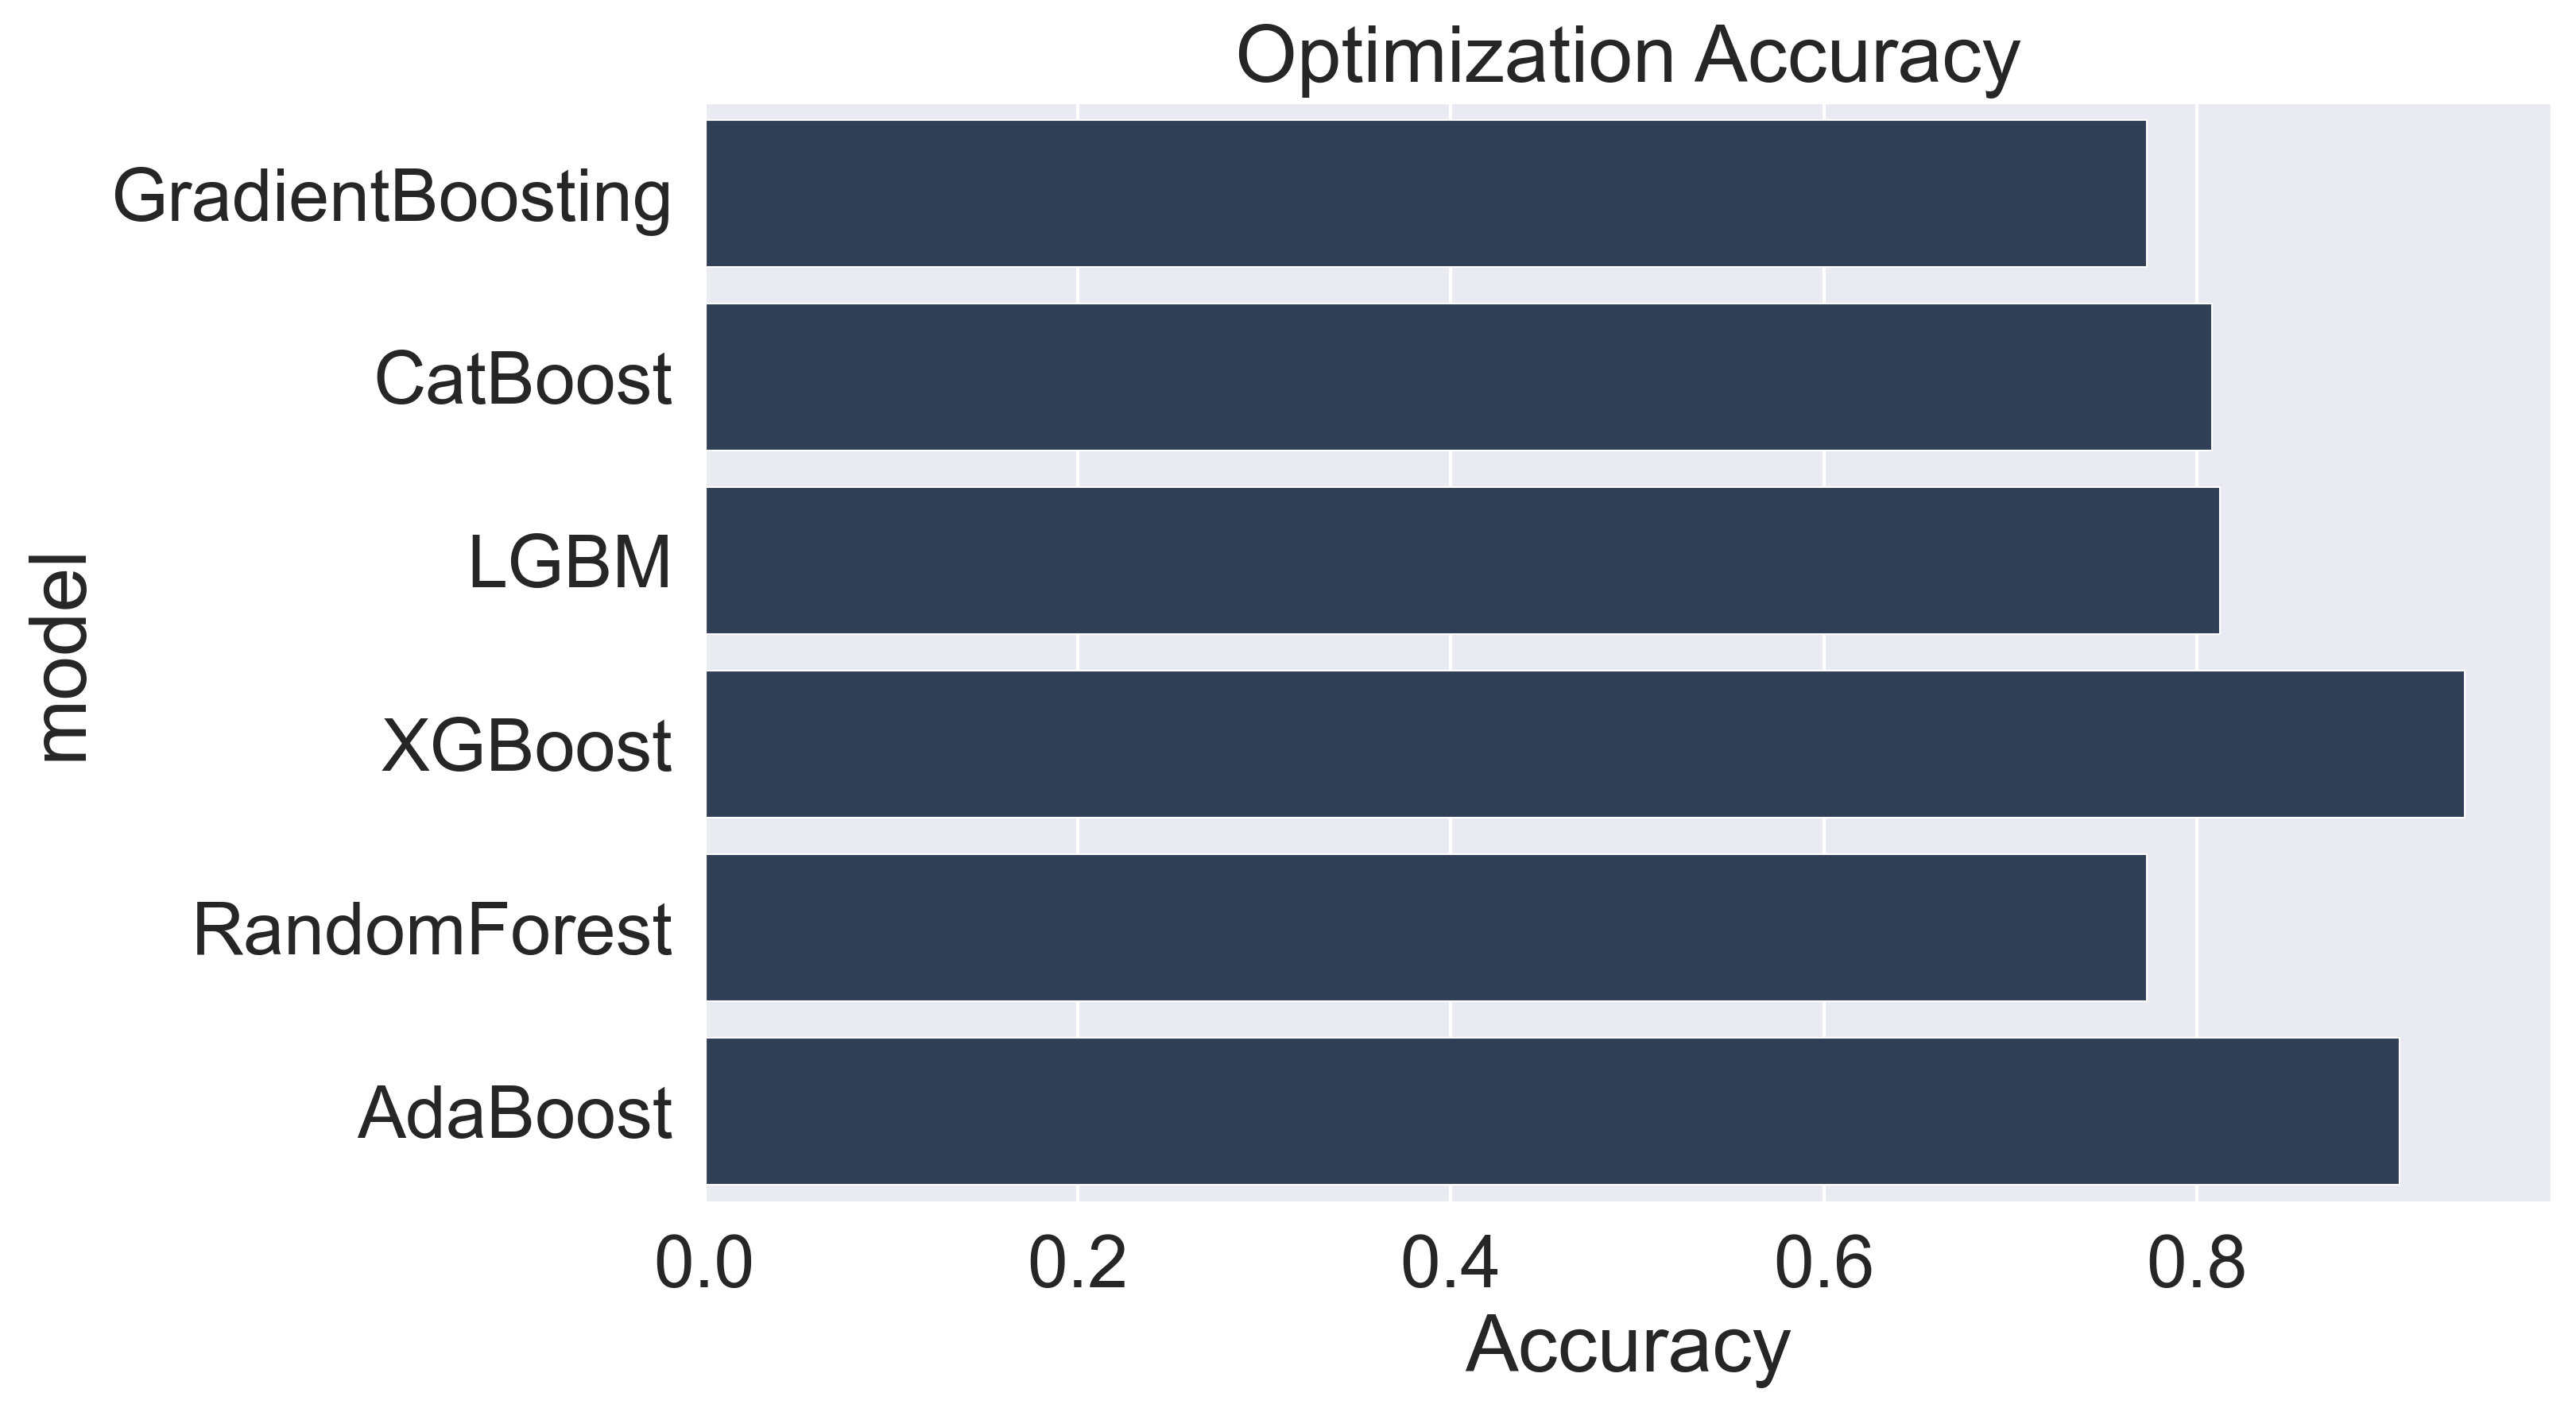

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(10, 6),dpi = 300)

# 가로막대그래프 그리기
sns.barplot(x='accuracy', y='model', data=df_optimization, color='#293C5D',linewidth=0.5)
sns.set(font_scale=2)
# x축 레이블 설정
plt.xlabel('Accuracy')

# 그래프 타이틀 설정
plt.title('Optimization Accuracy')

# 그래프 보여주기
plt.show()

In [104]:
result_df

,0,1,2,3,4,mean
GradientBoosting,0.760870,0.826087,0.847826,0.847826,0.800000,0.816522
CatBoost,0.782609,0.869565,0.869565,0.782609,0.755556,0.811981
XGBoost,0.804348,0.760870,0.847826,0.826087,0.777778,0.803382
LGBM,0.695652,0.891304,0.760870,0.804348,0.733333,0.777101
AdaBoost,0.739130,0.782609,0.739130,0.847826,0.688889,0.759517
RandomForest,0.652174,0.782609,0.782609,0.717391,0.711111,0.729179


In [113]:
result_df = result_df.drop(columns=[0, 1, 2, 3, 4])

,index,mean
0,GradientBoosting,0.816522
1,CatBoost,0.811981
2,XGBoost,0.803382
3,LGBM,0.777101
4,AdaBoost,0.759517
5,RandomForest,0.729179


In [115]:
result_df = result_df.reset_index()
result_df = result_df.rename(columns={'index': 'model'})

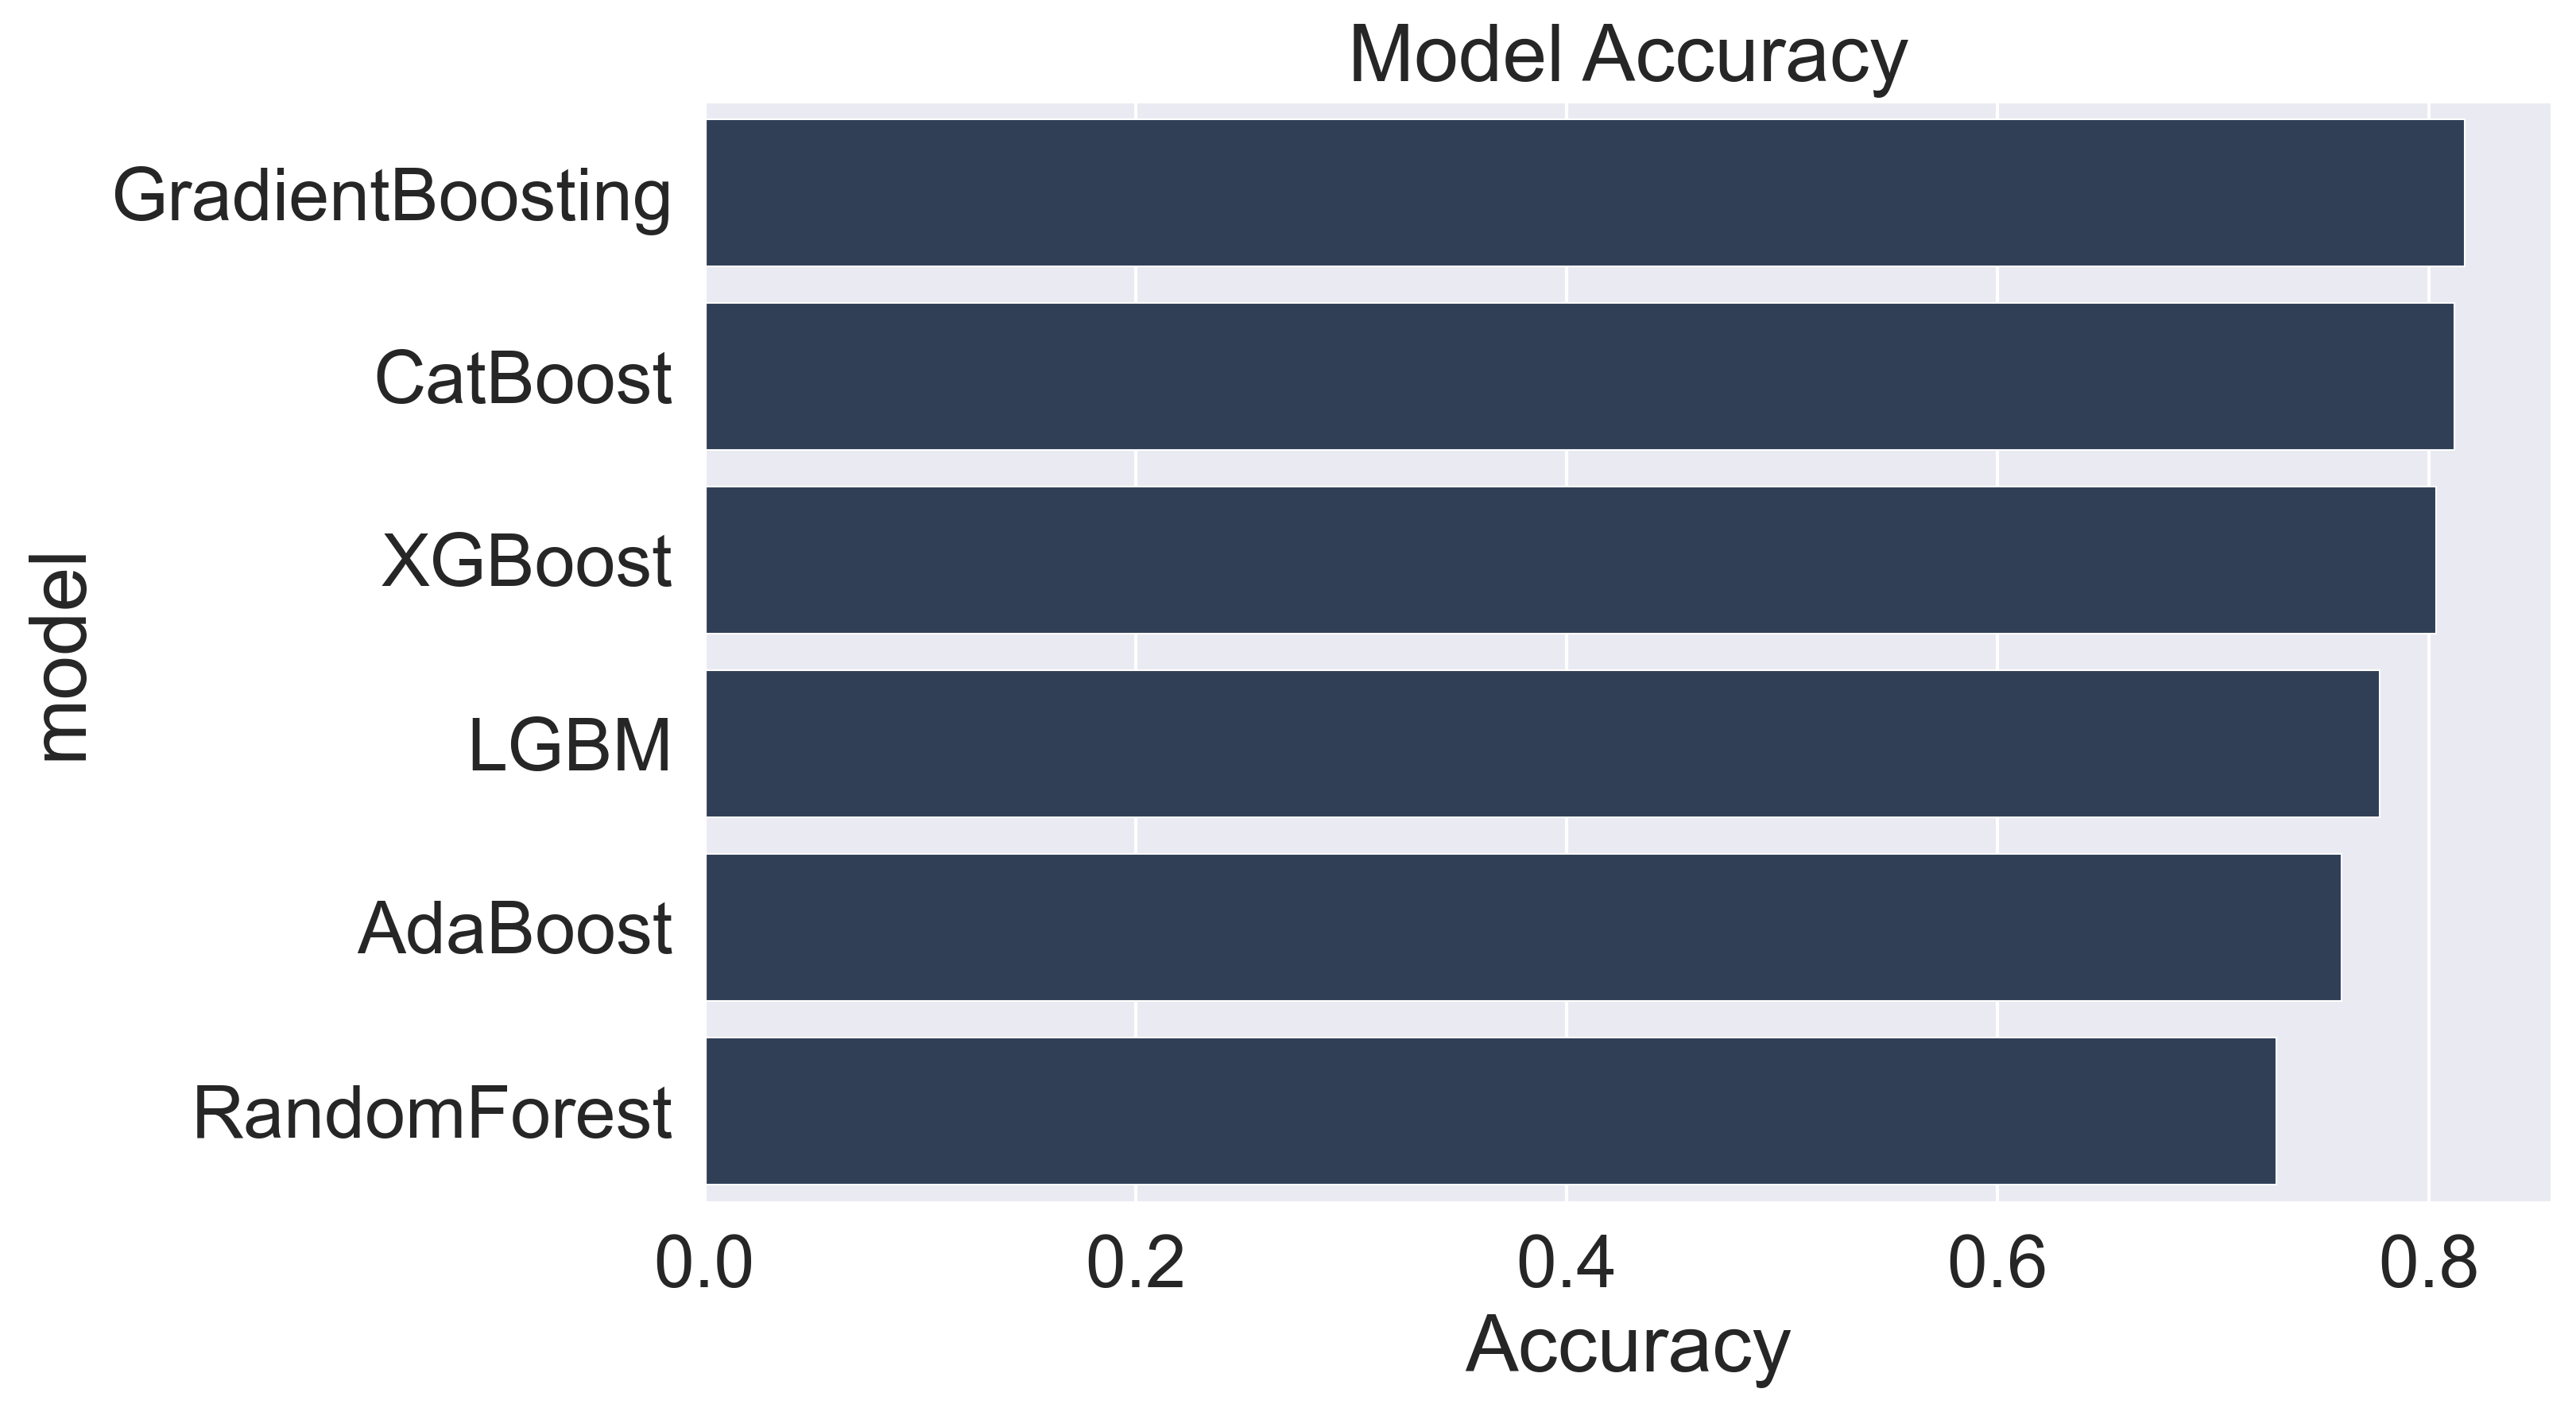

In [116]:
# 그래프 크기 설정
plt.figure(figsize=(10, 6),dpi = 300)

# 가로막대그래프 그리기
sns.barplot(x='mean', y='model', data=result_df, color='#293C5D',linewidth=0.5)
sns.set(font_scale=2)
# x축 레이블 설정
plt.xlabel('Accuracy')

# 그래프 타이틀 설정
plt.title('Model Accuracy')

# 그래프 보여주기
plt.show()

In [108]:
# with open('df_optimization.pickle', 'wb') as f:
#     pickle.dump(df_optimization, f)

In [109]:
# with open('result_df.pickle', 'wb') as f:
#     pickle.dump(result_df, f)

## XGB로 feature importance 확인

In [117]:
features = d_input
feature = features.columns

In [118]:
df_fi = pd.DataFrame(columns = ['feature', 'importance'])

In [119]:
df_fi['feature'] = feature
df_fi['importance'] = xgb_fi

In [120]:
df_fi_30 = df_fi.sort_values(by = 'importance', ascending=False)
df_fi_30 = df_fi_30[:30]
len(df_fi_30)

30

In [121]:
plt.rcParams['font.family'] = 'NanumGothic'

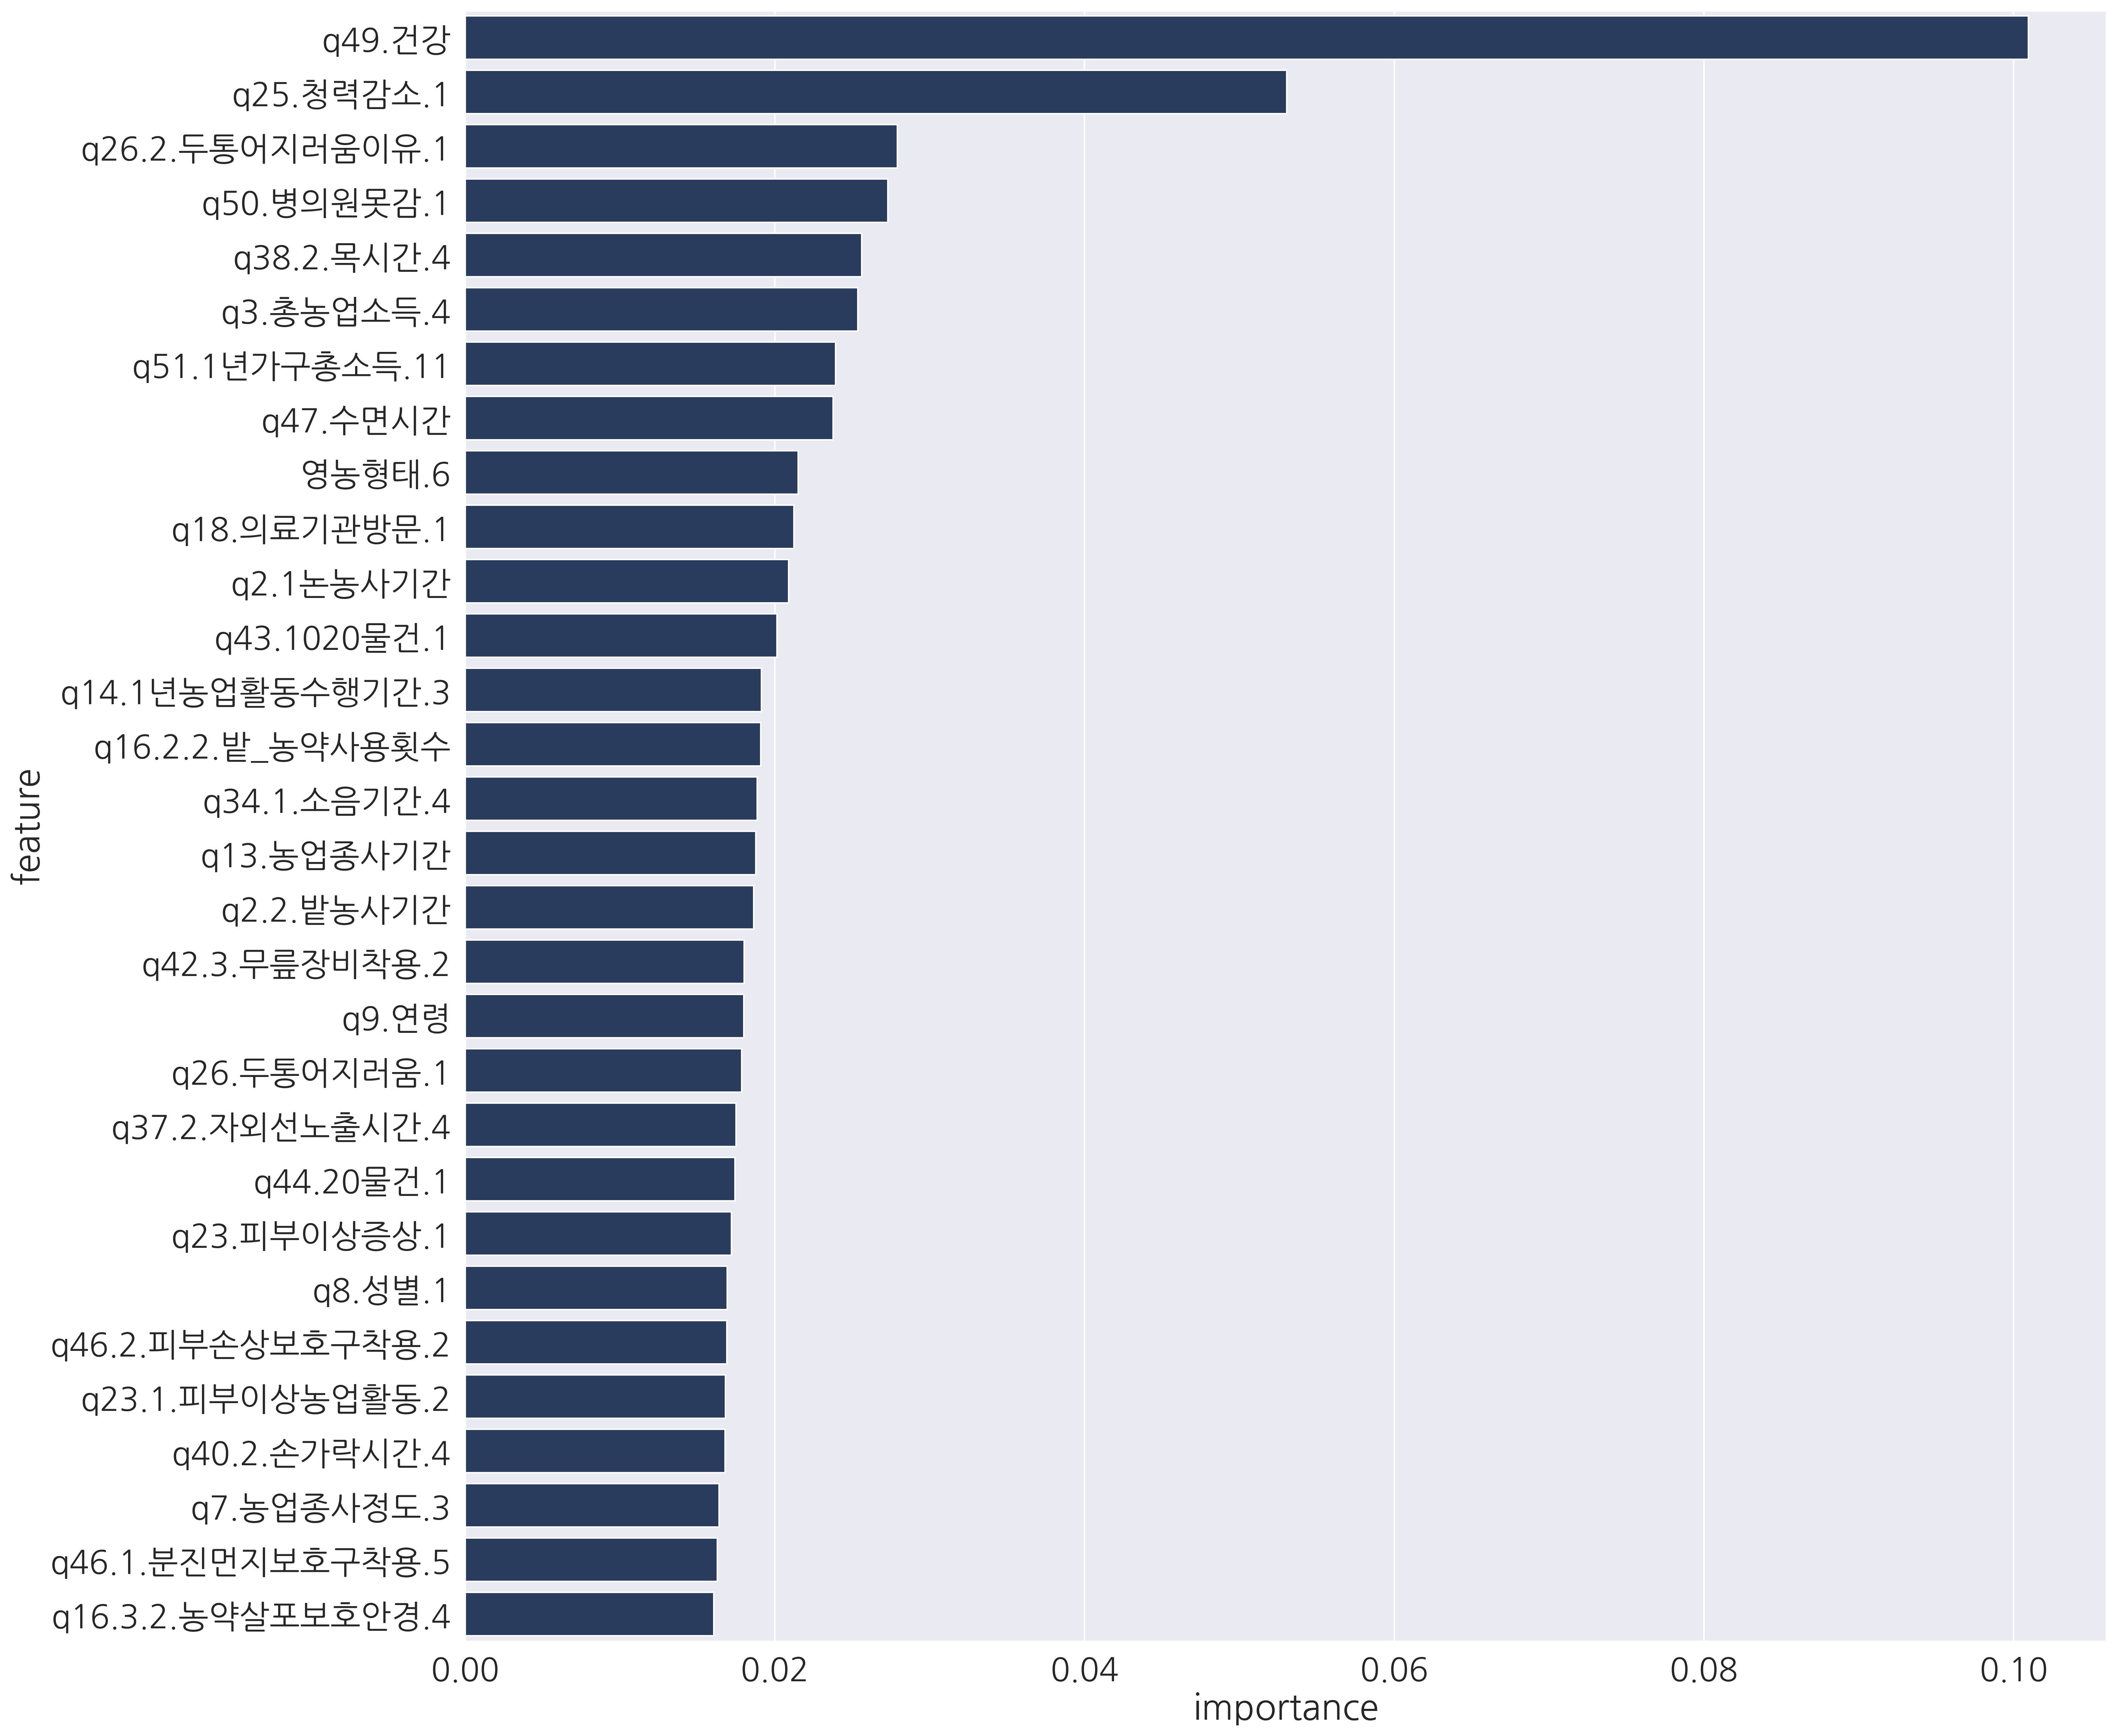

In [122]:
plt.figure(figsize=(20, 20), dpi = 300)

ax = sns.barplot(x='importance',
                 y='feature',
                 data=df_fi_30,
                 orient='h',
                 color='#203966')

sns.set(font_scale=3)

In [125]:
# xgb = XGBClassifier(n_estimators=100, random_state=0)
# xgb.fit(x_train,y_train)

features = d_input
x, y = (list(x) for x in zip(*sorted(zip(xgb_fi, features), reverse = False)))

trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='XGBoost Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2100,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

In [126]:
importance_descending = sorted(zip(xgb_fi, features),reverse = True)
importance_descending[:20]

[(0.10094351, 'q49.건강'),
 (0.053066228, 'q25.청력감소.1'),
 (0.027917188, 'q26.2.두통어지러움이유.1'),
 (0.027299613, 'q50.병의원못감.1'),
 (0.025619617, 'q38.2.목시간.4'),
 (0.025365219, 'q3.총농업소득.4'),
 (0.02392216, 'q51.1년가구총소득.11'),
 (0.023757737, 'q47.수면시간'),
 (0.021514118, '영농형태.6'),
 (0.021232868, 'q18.의료기관방문.1'),
 (0.020897128, 'q2.1논농사기간'),
 (0.02013694, 'q43.1020물건.1'),
 (0.019130304, 'q14.1년농업활동수행기간.3'),
 (0.019096162, 'q16.2.2.밭_농약사용횟수'),
 (0.018876508, 'q34.1.소음기간.4'),
 (0.018780272, 'q13.농업종사기간'),
 (0.018649876, 'q2.2.밭농사기간'),
 (0.018024955, 'q42.3.무릎장비착용.2'),
 (0.018012319, 'q9.연령'),
 (0.017861666, 'q26.두통어지러움.1')]

## AUC-ROC Curve

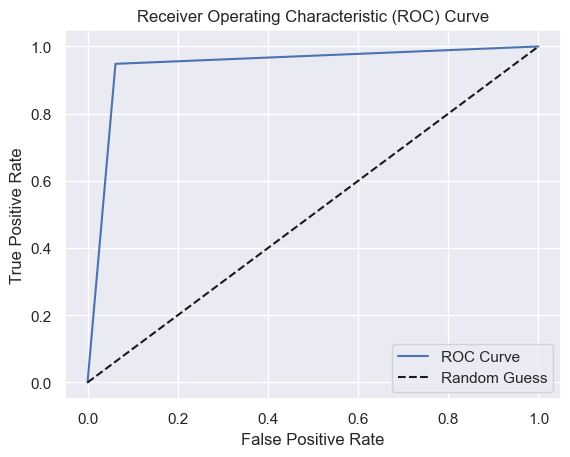

AUC-ROC score: 0.9432


In [134]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# 모델이 예측한 확률값과 실제 클래스 레이블을 입력으로 받습니다.
# (y_pred는 0과 1 사이의 확률값, y_true는 0 또는 1)
fpr, tpr, thresholds = roc_curve(y_test, xgb_y_pred)

# ROC curve 그리기
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
sns.set(font_scale=2)

# AUC-ROC 점수 계산
auc_roc = roc_auc_score(y_test, xgb_y_pred)
print(f"AUC-ROC score: {auc_roc:.4f}")

## Confusion Matrix

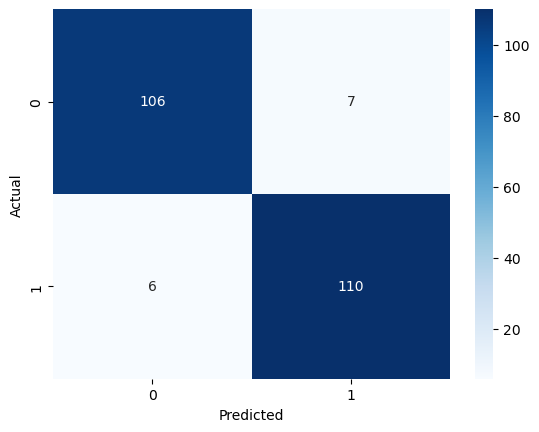

In [6]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 예측값과 실제값이 들어있는 배열을 생성합니다. 
predicted = xgb_y_pred
actual = y_test

# confusion matrix를 계산합니다. 
cm = confusion_matrix(actual, predicted)

# seaborn 라이브러리를 사용하여 heatmap으로 confusion matrix를 그립니다. 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 평균, 표준편차

In [65]:
train_1=pd.concat([x_train,y_train],axis=1)
test_1=pd.concat([x_test,y_test],axis=1)
all_1=pd.concat([train_1,test_1])
all_1

,q2.1.논농사수행여부.1,q2.1.논농사수행여부.2,q2.2.밭농사수행여부.1,q2.2.밭농사수행여부.2,q2.3.과수원수행여부.1,q2.3.과수원수행여부.2,q2.3.과수원기간.1,q2.3.과수원기간.2,q2.3.과수원기간.3,q2.3.과수원기간.4,...,q13.농업종사기간,q16.2.1.논_농약사용횟수,q16.2.2.밭_농약사용횟수,q16.2.3.과수_농약사용횟수,q32.일못한일수기타1,q33.3.치료비용1,q33.4.치료보험금액1,q47.수면시간,q49.건강,target
3260,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,20.0,4.0,0.0,0.0,0.0,0.0,0.0,7.0,3.0,0
1640,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,45.0,0.0,10.0,0.0,0.0,0.0,0.0,5.0,3.0,1
508,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,50.0,0.0,3.0,0.0,0.0,0.0,0.0,8.0,5.0,1
9300,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,59.0,0.0,0.0,0.0,0.0,1000000.0,0.0,7.0,5.0,1
6186,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,40.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10282,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,6.0,0.0,10.0,0.0,0.0,0.0,0.0,8.0,3.0,0
5796,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,30.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,2.0,1
3368,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,47.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,1
8556,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,15.0,0.0,30.0,0.0,0.0,0.0,0.0,8.0,4.0,1


In [66]:
target0=all_1[all_1['target']==0]
target1=all_1[all_1['target']==1]

In [67]:
target0.index

Int64Index([ 3260,  6186,  8709,  6836,  3871,  2565,  3852,   718, 10112,
             7165,
            ...
             5124,  6771,  2092,  7388,  1880,  6463,  8321,  2632, 10282,
             6971],
           dtype='int64', length=457)

In [68]:
target0=df.loc[target0.index]
target1=df.loc[target1.index]
target0['q47.수면시간'].mean()


6.700218818380744

In [69]:
target1['q47.수면시간'].mean()

5.435448577680525

In [70]:
target0['q2.1논농사기간'].mean()

20.667396061269148

In [72]:
target1['q2.1논농사기간'].mean()

24.533916849015316

In [ ]:
target0['q47.수면시간'].mean()

In [ ]:
target1['q47.수면시간'].mean()